In [2]:
import numpy as np
import pandas as pd
from matplotlib import animation, rc
from IPython.display import HTML
import imageio
import os
import glob
import matplotlib.pyplot as plt
import json
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import animation, rc, cm
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from keras_self_attention import SeqSelfAttention



In [3]:
from tensorflow.keras.models import load_model
model = load_model('/Users/catherinekim/Desktop/VRTL/best_model.keras')

In [2]:
#ready input file for classifier

direc = '/Users/catherinekim/Desktop/VRTL'
participants = ['VRTL3', 'VRTL6', 'VRTL9', 'VRTL10', 'VRTL11']
#participants = ['VRTL3']
session_label = ['S3','S4']
camera = 'Camera6'

entire_data = []
# Loop through each participant to extract the S4 entropy
for participant in participants:
    # Construct the file path for each participant's entropy file
    for session in session_label:
        file_path = f"{direc}/{participant}/eyetracking/preprocessed/preprocessed_{participant}{session}_{camera}.csv"
        data = pd.read_csv(file_path)

        label = 0 if session == 'S3' else 1 #label 0 = X zombie; label 1= zombie

        #adding columns
        data['label'] = label
        data['participant'] = participant
        data['session'] = session

        filtered_data = data[['participant','timepoint', 'x_pos_pixel','y_pos_pixel','session','label']]
        
        entire_data.append(filtered_data)
    
combined_data = pd.concat(entire_data, ignore_index = True)
#output_file = f"{direc}/VRTL_input_classifier.csv"
#combined_data.to_csv(output_file, index=False)

In [28]:
#input file for S5 + S6

direc = '/Users/catherinekim/Desktop/VRTL'
participants = ['VRTL3', 'VRTL6', 'VRTL7','VRTL8', 'VRTL9','VRTL10', 'VRTL11']
#participants = ['VRTL3']
flip_label = ['VRTL6','VRTL8','VRTL9','VRTL10']
session_label = ['S5','S6']
camera = 'Camera6'

# Dictionary to store data for easy access and analysis
session_A = [] #temporally distant 
session_B = [] #temporally closer

# Loop through each participant to extract the S4 entropy
for participant in participants:
    if participant in flip_label: 
        #path_session_B = f"{direc}/{participant}/eyetracking/preprocessed/preprocessed_{participant}S5_{camera}.csv"
        #session_A = f"{direc}/{participant}/eyetracking/preprocessed/preprocessed_{participant}S6_{camera}.csv"
        participant_sessionB = pd.read_csv(f"{direc}/{participant}/eyetracking/preprocessed/preprocessed_{participant}S5_{camera}.csv")
        participant_sessionA = pd.read_csv(f"{direc}/{participant}/eyetracking/preprocessed/preprocessed_{participant}S6_{camera}.csv")
        participant_sessionB['participant'] = participant
        participant_sessionA['participant'] = participant
        
    else:
        participant_sessionA = pd.read_csv(f"{direc}/{participant}/eyetracking/preprocessed/preprocessed_{participant}S5_{camera}.csv")
        participant_sessionB = pd.read_csv(f"{direc}/{participant}/eyetracking/preprocessed/preprocessed_{participant}S6_{camera}.csv")
        participant_sessionB['participant'] = participant
        participant_sessionA['participant'] = participant
        
    session_A.append(participant_sessionA)
    session_B.append(participant_sessionB)

combined_sessionA = pd.concat(session_A, ignore_index = True)
combined_sessionB = pd.concat(session_B, ignore_index = True)


In [4]:
#test S1 + S2

direc = '/Users/catherinekim/Desktop/VRTL'
participants = ['VRTL3', 'VRTL6', 'VRTL8', 'VRTL9', 'VRTL10', 'VRTL11']
#participants = ['VRTL3']
session_label = ['S1','S2']
camera = 'Camera6'

entire_data = []
# Loop through each participant to extract the S4 entropy
for participant in participants:
    # Construct the file path for each participant's entropy file
    for session in session_label:
        file_path = f"{direc}/{participant}/eyetracking/preprocessed/preprocessed_{participant}{session}_{camera}.csv"
        data = pd.read_csv(file_path)
        data['participant'] = participant

        filtered_data = data[['participant','timepoint', 'x_pos_pixel','y_pos_pixel']]
        
        entire_data.append(filtered_data)
    
S1_S2_combined_data = pd.concat(entire_data, ignore_index = True)
#output_file = f"{direc}/VRTL_input_classifier.csv"
#combined_data.to_csv(output_file, index=False)

In [5]:
def create_sequences(data, sequence_length=1500, stride=40):
    grouped_data = data.groupby('participant')  # Group by participants
    sequences = []
    scaler = MinMaxScaler()

    # Iterate through each participant's data
    for participant, group in grouped_data:
        # Extract features
        features = group[['timepoint', 'x_pos_pixel', 'y_pos_pixel']].values
        features_scaled = scaler.fit_transform(features)

        # Create sequences using a sliding window
        for i in range(0, len(features_scaled) - sequence_length + 1, stride):
            sequence = features_scaled[i:i+sequence_length]
            sequences.append(sequence)
    
    return np.array(sequences)

In [6]:
sequences = create_sequences(S1_S2_combined_data)
probabilities_S1S2 = model.predict(sequences)
np.mean(probabilities_S1S2,axis=0)

59/59 ━━━━━━━━━━━━━━━━━━━━ 22s 363ms/step


array([0.41305277, 0.58694744], dtype=float32)

array([0.33287635, 0.6671238 ], dtype=float32)

In [58]:
sequences_sessionA = create_sequences(combined_sessionA)
sequences_sessionB = create_sequences(combined_sessionB)

probabilities_sessionA = model.predict(sequences_sessionA) #temporally distant
probabilities_sessionB = model.predict(sequences_sessionB) #temporally closer

avg_probabilities_sessionA = np.mean(probabilities_sessionA[len(probabilities_sessionA):], axis=0)
avg_probabilities_sessionB = np.mean(probabilities_sessionB[len(probabilities_sessionB):], axis=0)

28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 396ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 399ms/step


/Users/catherinekim/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/catherinekim/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [59]:
print(avg_probabilities_sessionA)
print(avg_probabilities_sessionB)

[nan nan]
[nan nan]


<Axes: ylabel='Count'>

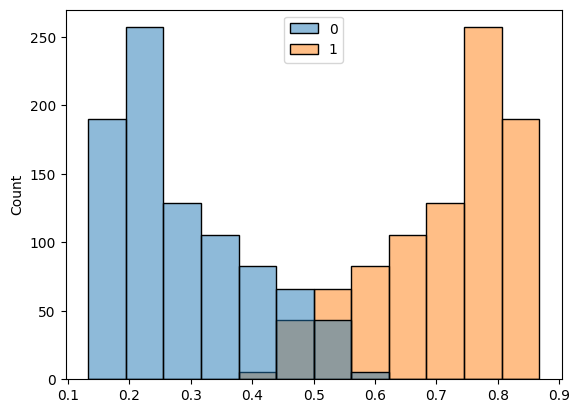

In [43]:
sns.histplot(probabilities_sessionA)

<Axes: ylabel='Count'>

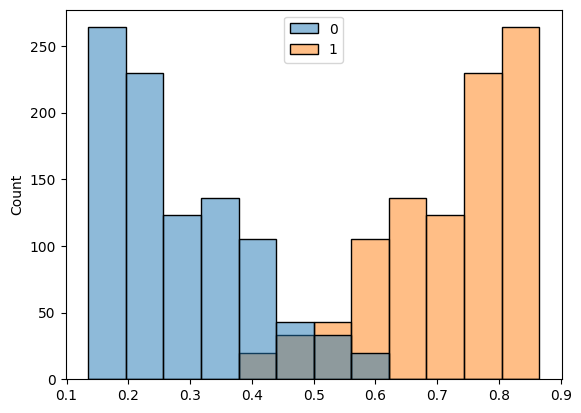

In [44]:
sns.histplot(probabilities_sessionB)

In [46]:
# Print results

avg_probabilities_sessionA = np.mean(probabilities_sessionA, axis=0)
avg_probabilities_sessionB = np.mean(probabilities_sessionB, axis=0)

print("Session A Probabilities (for labels 0 and 1):")
print(avg_probabilities_sessionA)
print("Session B Probabilities (for labels 0 and 1):")
print(avg_probabilities_sessionB)


# print("\nSession 5 Probabilities (for labels 0 and 1):")
# print(probabilities_sessionB)

Session A Probabilities (for labels 0 and 1):
[0.28827178 0.7117288 ]
Session B Probabilities (for labels 0 and 1):
[0.2846849 0.7153155]


In [3]:
X = combined_data[['timepoint','x_pos_pixel', 'y_pos_pixel']].values
y = combined_data['label'].values

#normalize to improve model performance
scaler = MinMaxScaler()
X = scaler.fit_transform(X)


In [10]:
grouped_data = combined_data.groupby(['participant']) #group by participants

#sequence_length = 2500 # change length for contextual information The zombie sequence is around 3000
sequence_length = 2500
stride = 40

X_sequences = []
y_labels = []

for participant, group in grouped_data: #RNN- creating sequences seperating participants
    # Extract features and labels for this participant
    X_participant = group[['timepoint', 'x_pos_pixel', 'y_pos_pixel']].values
    y_participant = group['label'].values

    # Create sequences for this participant
    for i in range(0, len(X_participant) - sequence_length + 1, stride):
        sequence = X_participant[i:i+sequence_length]
        label = y_participant[i+sequence_length-1]  # Label based on the last time step
        X_sequences.append(sequence)
        y_labels.append(label)

In [11]:
X_padded = pad_sequences(X_sequences, padding='post', dtype='float32') #Padding: for LSTM- X needs to have same size
y_categorical = to_categorical(y_labels) #convert to one-hot encoding


In [12]:
#train + split data
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_categorical, test_size=0.2, random_state=42)

In [57]:
model = Sequential([
    # First LSTM layer (returns sequences for stacking)
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.5),  # Dropout for regularization
    # SeqSelfAttention(attention_width=15, #attention mechanism to focus on most important timesteps
    #                  attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,  # Multiplicative attention
    #                  attention_activation='softmax'),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    LSTM(32, activation='tanh', return_sequences=False),  # New LSTM layer
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')  # Output layer for binary classification
])

Optimizer = Adam(learning_rate=0.00005)
# Compile the model
model.compile(optimizer = Optimizer, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

checkpoint = ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

#model.summary()
#early stopping for when model stops learning in training.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) 
# Train the model
history = model.fit(X_train, y_train, epochs=40, batch_size=16, validation_split=0.2, callbacks=[checkpoint,early_stopping]) #earlystopping to mitigate overfitting

Epoch 1/40


/Users/catherinekim/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5586 - loss: 0.6788 - precision: 0.5586 - recall: 0.5586
Epoch 1: val_loss improved from inf to 0.65076, saving model to best_model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 192s 3s/step - accuracy: 0.5589 - loss: 0.6787 - precision: 0.5589 - recall: 0.5589 - val_accuracy: 0.6720 - val_loss: 0.6508 - val_precision: 0.6720 - val_recall: 0.6720
Epoch 2/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5848 - loss: 0.6686 - precision: 0.5848 - recall: 0.5848
Epoch 2: val_loss improved from 0.65076 to 0.62149, saving model to best_model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.5851 - loss: 0.6684 - precision: 0.5851 - recall: 0.5851 - val_accuracy: 0.7000 - val_loss: 0.6215 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 3/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6685 - loss: 0.6323 - precision: 0.6685 - recall: 0.6685
Epoch 3: val_loss improved from 0.62149 to 0.58906, saving model to best_model.keras
63/6

In [21]:

#save model
model.save('/Users/catherinekim/Desktop/VRTL/best_model.keras')


In [1]:
from tensorflow.keras.models import load_model
model = load_model('/Users/catherinekim/Desktop/VRTL/best_model.keras')

/Users/catherinekim/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [16]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 568ms/step - accuracy: 0.9060 - loss: 0.2320
test_loss: 0.2160763442516327
test_accuracy: 0.9169328808784485


In [ ]:
import matplotlib.pyplot as plt
for sequence in X_sequences[:5]:  # Plot first few sequences
    plt.plot(sequence[:, 0], sequence[:, 1])  # Plot x_pos_pixel vs. y_pos_pixel
    plt.show()

In [14]:
print(f"Total number of samples: {len(X_padded)}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Total number of samples: 10
Training samples: 8
Test samples: 2


In [15]:
print(data.groupby(['participant', 'label']).size())

participant  label
VRTL11       1        7164
dtype: int64
